In [ ]:
setwd("~/projects/next_gen_attribution/src/analysis/path_analysis/R")

source("~/R_connector/libraries.R")
mozart <- connToEDW(dataBase = "Mozart", connType = 'normal', user = 'pgurican', pass=trimws(read_file("~/R_connector/p.txt")))
hopper <- connToEDW(dataBase = "Hopper", connType = 'normal', user = 'pgurican', pass=trimws(read_file("~/R_connector/p.txt")))

Loading required package: DBI
Loading required package: rJava
------------------------------------------------------------------------------
data.table + dplyr code now lives in dtplyr.
Please library(dtplyr)!
------------------------------------------------------------------------------

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract


Attaching package: ‘DescTools’

The following object is masked from ‘package:data.table’:

    %like%



# Co-occurences

In [2]:
co_occurences <- dbGetQuery(conn = hopper, "select * from P_TRAFFIC_T.MTA_ORDERED_PATH_COOCURENCES order by path_length")

In [3]:
co_occurences

path_length,coocurences


In [16]:
getCooccurenceDF <- function(co_occurences, path_length_var = 40)
{
    coocs <- (co_occurences %>% 
                  filter(path_length == path_length_var) %>%
                  mutate(split = strsplit(coocurences, ";")))$split[[1]]
    
    cooc_df <- do.call(rbind.data.frame, lapply(coocs, function(x) {
        comma_pos <- StrPos(x, ",")
        left_brace_pos <- StrPos(x, ")")

        l <- c(substr(x, 2, comma_pos - 1), substr(x, comma_pos + 1, left_brace_pos - 1))


        data.frame(channel_1 = l[1], 
                   channel_2 = l[2],
                   occurence = as.integer(substr(x, left_brace_pos + 5, nchar(x))))
    }))
    
    cooc_df$channel_1 <- as.factor(cooc_df$channel_1)
    cooc_df$channel_2 <- as.factor(cooc_df$channel_2)
    
    cooc_df_spread <- cooc_df %>% arrange(channel_1, channel_2) %>% spread(key = channel_1, value = occurence, fill= 0)
    
    cooc_df_gather <- (cooc_df_spread %>% gather(channel_1, occurence, -channel_2))[c(2,1,3)]
    cooc_df_gather$channel_1 <- as.factor(cooc_df_gather$channel_1)
    cooc_df_gather$channel_2 <- factor(cooc_df_gather$channel_2, levels = levels(cooc_df_gather$channel_1))
    
    cooc_df_gather %<>% arrange(channel_1, channel_2)
    
    m <- as.matrix(cooc_df_gather %>% spread(key = channel_1, value = occurence, fill = 0))
    m <- m[,-1]
    m <- apply(m, 1, as.integer)
    rownames(m) <- colnames(m)
    signs <- sign(m - t(m))
    signs <- melt(signs, 
                  varnames = c("channel_1", "channel_2"), value.name = "comparison") %>% 
                arrange(channel_1, channel_2)
    
    difference <- (m - t(m))
    difference <- melt(difference,
                       varnames = c("channel_1", "channel_2"), value.name = "difference") %>% 
                    arrange(channel_1, channel_2)

    
    relative_difference <- (m - t(m))/apply((m + t(m)), c(1, 2), function(x) max(x,1))
    relative_difference <- melt(relative_difference,
                       varnames = c("channel_1", "channel_2"), value.name = "relative_difference") %>% 
                    arrange(channel_1, channel_2)

    
    cooc_df_gather$comparison <- as.factor(signs$comparison)
    cooc_df_gather$difference <- difference$difference
    cooc_df_gather$relative_difference <- relative_difference$relative_difference
    
    cooc_df_gather
}

### Absolute differences

Saving 6.67 x 6.67 in image


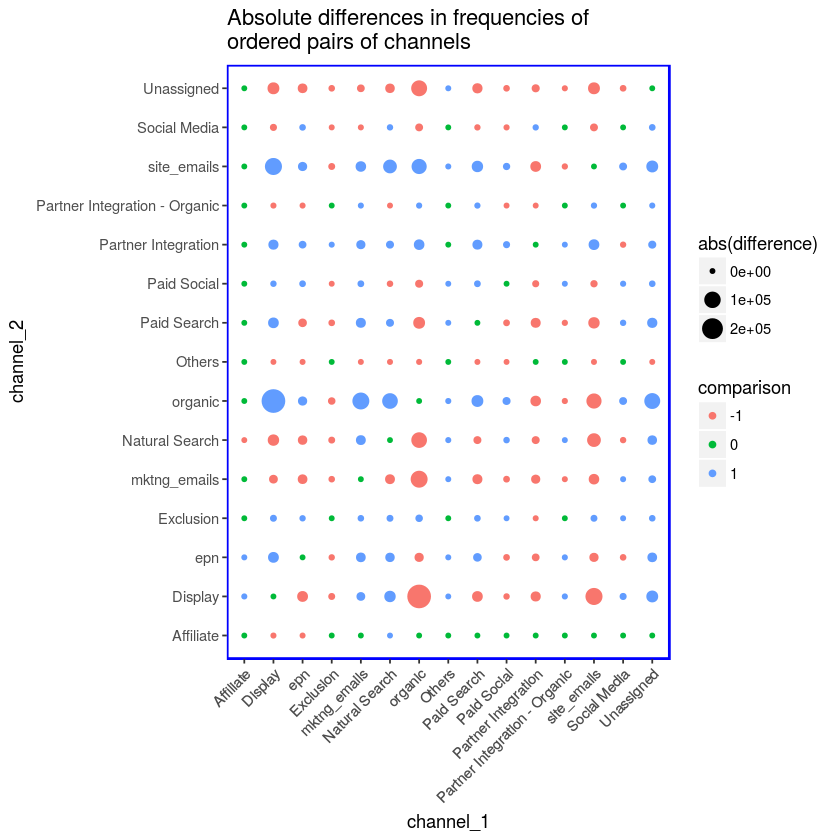

In [19]:
ggplot(data = getCooccurenceDF(co_occurences, path_length_var = 40)
                #filter(!(channel_1 %in% c('organic', 'Unassigned'))) %>% 
                #filter(!(channel_2 %in% c('organic','Unassigned'))) %>%
                # filter(as.character(channel_1) > as.character(channel_2))
               ,
       aes(x=channel_1, 
           y=channel_2)) + 
  geom_point(aes(size = abs(difference), color = comparison)) +
  scale_fill_manual(values=c("-1" = "#c62828", "0" = "#1565C0", "1"="#2E7D32")) +
  theme(panel.background=element_blank(),
        panel.border = element_rect(colour = "blue", fill=NA, size=1),
        axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
  ggtitle("Absolute differences in frequencies of \nordered pairs of channels")

ggsave("figs/absolute_difference_ordered_coocurences.pdf")

The above is a plot of differences between number of (channel_1, channel_2) ordered pairs and (channel_2, channel_1) ordered pairs in paths with a given path length. 

Size of the bubble indicates the magnitude of the difference. 

Blue bubble means that there are more (channel_1, channel_2) pairs in the natural time ordering.
Red bubble means that there are more (channel_2, channel_1) pairs in the natural time ordering, so channel_1 is actually more often closer to the transaction.
Green bubble means that the number of pairs is equal (and often 0 or close to 0).

### Relative differences

Saving 6.67 x 6.67 in image


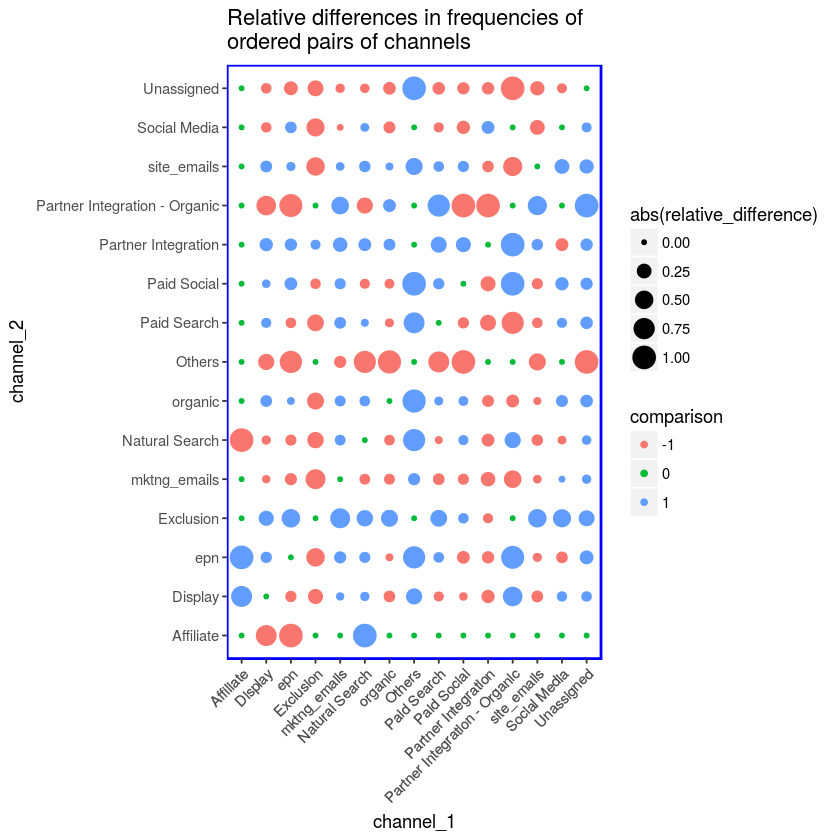

In [14]:
ggplot(data = getCooccurenceDF(co_occurences, path_length_var = 40),# %>% 
                #filter(!(channel_1 %in% c('organic', 'Unassigned'))) %>% 
                #filter(!(channel_2 %in% c('organic','Unassigned'))) %>%
                #filter(as.character(channel_1) > as.character(channel_2)),
       aes(x=channel_1, 
           y=channel_2)) + 
  geom_point(aes(size = abs(relative_difference), color = comparison)) +
  scale_fill_manual(values=c("-1" = "#c62828", "0" = "#1565C0", "1"="#2E7D32")) +
  theme(panel.background=element_blank(),
        panel.border = element_rect(colour = "blue", fill=NA, size=1),
        axis.text.x = element_text(angle = 45, vjust = 1, hjust=1)) +
  ggtitle("Relative differences in frequencies of \nordered pairs of channels")
ggsave(paste("figs/relative_difference_ordered_coocurences", ".pdf", sep = ""))